In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math

<!-- Provide an overview of this section or a summary of the concepts covered here -->
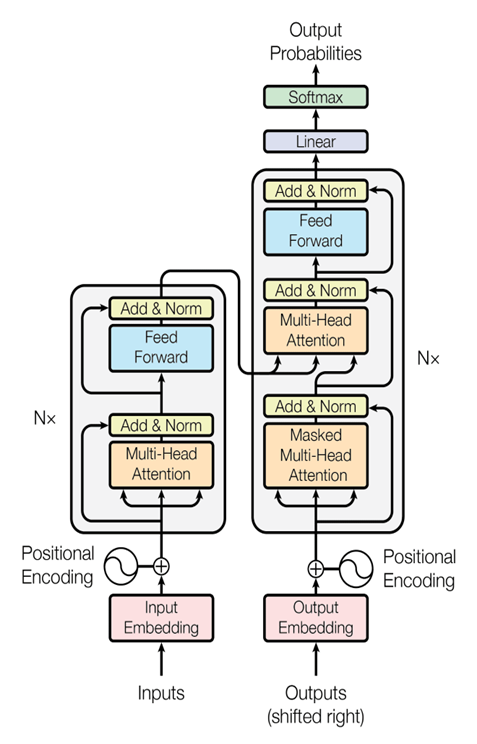

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    # Ensure that the model dimension (d_model) is divisible by the number of heads
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    # Initialize dimensions
    self.d_model = d_model # Model's dimension
    self.num_heads = num_heads # Number of attention heads
    self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

    # Linear layers for transforming inputs
    self.W_q = nn.Linear(d_model, d_model) # Query transformation
    self.W_k = nn.Linear(d_model, d_model) # Key transformation
    self.W_v = nn.Linear(d_model, d_model) # Value transformation
    self.W_o = nn.Linear(d_model, d_model) # Output transformation

  def scaled_dot_product_attention(self, Q, K, V, mask=None):
    # Calculate attention scores
    attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

    # Apply mask if provided (useful for preventing attention to certain parts like padding)
    if mask is not None:
      attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

    # Softmax is applied to obtain attention probabilities
    attn_probs = torch.softmax(attn_scores, dim=-1)

    # Multiply by values to obtain the final output
    output = torch.matmul(attn_probs, V)
    return output

  def split_heads(self, x):
    # Reshape the input to have num_heads for multi-head attention
    batch_size, seq_length, d_model = x.size()
    return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

  def combine_heads(self, x):
    # Combine the multiple heads back to original shape
    batch_size, _, seq_length, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

  def forward(self, Q, K, V, mask=None):
    # Apply linear transformations and split heads
    Q = self.split_heads(self.W_q(Q))
    K = self.split_heads(self.W_k(K))
    V = self.split_heads(self.W_v(V))

    # Perform scaled dot-product attention
    attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

    # Combine heads and apply output transformation
    output = self.W_o(self.combine_heads(attn_output))
    return output

<!-- Provide an overview of this section or a summary of the concepts covered here -->
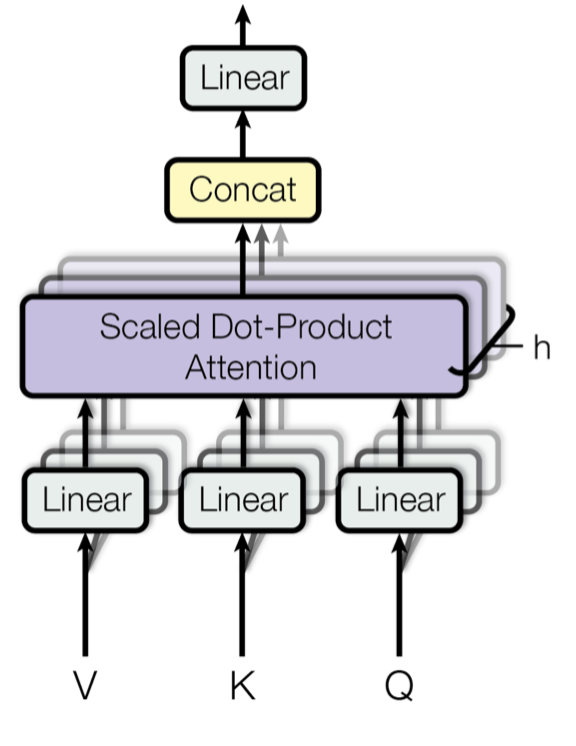

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
class PositionWiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    super(PositionWiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(d_model, d_ff)
    self.fc2 = nn.Linear(d_ff, d_model)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super(PositionalEncoding, self).__init__()

    pe = torch.zeros(max_seq_length, d_model)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    return x + self.pe[:, :x.size(1)]

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    # Self-attention + Residual Connection + Layer Norm
    attn_output = self.self_attn(x, x, x, mask)
    x = self.norm1(x + self.dropout(attn_output))

    # Feed Forward + Residual Connection + Layer Norm
    ff_output = self.feed_forward(x)
    x = self.norm2(x + self.dropout(ff_output))

    return x

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super(DecoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
    self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_output, src_mask, tgt_mask):
    # Self-attention + Residual Connection + Layer Norm
    attn_output = self.self_attn(x, x, x, tgt_mask)
    x = self.norm1(x + self.dropout(attn_output))

    # Encoder-Decoder attention + Residual Connection + Layer Norm
    enc_dec_attn_output = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
    x = self.norm2(x + self.dropout(enc_dec_attn_output))

    # Feed Forward + Residual Connection + Layer Norm
    ff_output = self.feed_forward(x)
    x = self.norm3(x + self.dropout(ff_output))

    return x

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
    super(Transformer, self).__init__()
    self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
    self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

    self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    self.fc = nn.Linear(d_model, tgt_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def generate_mask(self, src, tgt):
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    tgt_mask = tgt_mask & nopeak_mask
    return src_mask, tgt_mask

  def forward(self, src, tgt):
    src_mask, tgt_mask = self.generate_mask(src, tgt)
    src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
    tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

    enc_output = src_embedded
    for enc_layer in self.encoder_layers:
        enc_output = enc_layer(enc_output, src_mask)

    dec_output = tgt_embedded
    for dec_layer in self.decoder_layers:
        dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

    output = self.fc(dec_output)
    return output

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
# Initialize parameters
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
# This cell performs the following actions:
# - Describe the primary function of this cell
# - Any significant libraries or modules used
# Generate validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# Evaluation mode
transformer.eval()

with torch.no_grad():
  val_output = transformer(val_src_data, val_tgt_data[:, :-1])
  val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
  print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.697040557861328
